<a href="https://colab.research.google.com/github/BrianSantos66/challenge-datascience-v2/blob/main/semana_3/semana_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação das dependências e configuração do ambiente

In [ ]:
# Instalação do PySpark e importação das bibliotecas
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType, IntegerType, LongType
from pyspark.sql import functions as f
from google.colab import drive
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Criação da seção
spark = SparkSession.builder\
    .master('local[*]')\
    .appName("selecao_features")\
    .config("spark.ui.port", '4050')\
    .getOrCreate()

In [ ]:
# Conectando no drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tratamento dos dados

In [ ]:
# Leitura do arquivo
df = spark.read.parquet("/content/drive/MyDrive/desafio_datascience/semana-1/parquet/base_tratada")
df.show(n=5)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+------------+--------+--------------+--------------+----------+----------+----+--------------------+------------+----------+----+-----+-------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|     cep|        cidade|        estado|  latitude| longitude|pais|                 rua|        zona|condominio|iptu| tipo|  valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+------------+--------+--------------+--------------+----------+----------+----+--------------------+------------+----------+----+-----+-------+
|    2|        35|       35|        1|[Academia, Churra...|00002dd9-cc74-480...|      1|  null|       Usado| Apartamento|Residencial|null|Santo Cristo|202

In [ ]:
# Contagem de dados nulos por coluna (Coluna "caracteristicas" removida pois esse tipo de contagem não funciona com listas)
df_drop = df.select("*").drop("caracteristicas")

frequencia_nulos = df_drop\
                    .select([f.count(f.when(f.col(c).contains('None') |\
                     f.col(c).contains('NULL') |\
                     (f.col(c) == '' ) |\
                     f.col(c).isNull() |\
                     f.isnan(c), c))\
                     .alias(c) for c in df_drop.columns])
frequencia_nulos.show()

+-----+----------+---------+---------+---+-------+------+------------+------------+--------+----+------+---+------+------+--------+---------+----+---+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros| id|quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso|vaga|bairro|cep|cidade|estado|latitude|longitude|pais|rua|zona|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---+-------+------+------------+------------+--------+----+------+---+------+------+--------+---------+----+---+----+----------+----+----+-----+
|    0|      9186|        0|        0|  0|      0|  5544|           0|           0|       0|3008|     0|  0|     0|     0|       1|        1|   0|  0|  11|      2347|7155|   0|    0|
+-----+----------+---------+---------+---+-------+------+------------+------------+--------+----+------+---+------+------+--------+---------+----+---+----+----------+----+----+-----+



In [ ]:
# Dropando colunas que não serão utilizadas no modelo (se tratam de colunas com valores únicos que prejudicariam o modelo)
df_features = df\
      .select("*")\
      .drop("tipo_anuncio", "tipo_unidade", "tipo_uso", "tipo", "area_total")

In [ ]:
# Tratamento das colunas colocando o tipo do dado correto
print("ANTES DO TRATAMENTO:")
df_features.printSchema()

lista_int = ['andar', "banheiros", "suites", "quartos"]
lista_db = ["area_util", "condominio", "iptu", "valor"]

for coluna in lista_int:
  df_features = df_features.withColumn(coluna, df_features[f"{coluna}"].cast(IntegerType()))

for coluna in lista_db:
  df_features = df_features.withColumn(coluna, df_features[f"{coluna}"].cast(DoubleType()))  

print("DEPOIS DO TRATAMENTO:")
df_features.printSchema()

ANTES DO TRATAMENTO:
root
 |-- andar: long (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- cep: string (nullable = true)
 |-- cidade: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- pais: string (nullable = true)
 |-- rua: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: integer (nullable = true)
 |-- iptu: integer (nullable = true)
 |-- valor: integer (nullable = true)

DEPOIS DO TRATAMENTO:
root
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- ca

In [ ]:
# Tratamento dos dados nulos na coluna "caracteristicas"
df_features = df_features\
              .withColumn("caracteristicas", f.when((f.size(f.col("caracteristicas")) == 0), f.lit(None))\
              .otherwise(f.col("caracteristicas")))

In [ ]:
# Tratamento dos dados nulos/missing
# Para colunas númericas os nulos foram substituidos por 0
# Nas colunas "zona" e "caracteristicas" linhas nulas foram ignoradas no select

df_features_tratado = df_features\
                      .select("*")\
                      .where("zona != ''")\
                      .where(f.size(f.col("caracteristicas")) > 0)\
                      .na\
                      .fill(0)

df_features_tratado.show()

+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+--------+--------------+--------------+----------+----------+----+--------------------+------------+----------+-------+---------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|              bairro|     cep|        cidade|        estado|  latitude| longitude|pais|                 rua|        zona|condominio|   iptu|    valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+--------+--------------+--------------+----------+----------+----+--------------------+------------+----------+-------+---------+
|    2|     35.0|        1|[Academia, Churra...|00002dd9-cc74-480...|      1|     0|   0|        Santo Cristo|20220410|Rio de Janeiro|Rio de Janeiro|-22.898243|-43.204903|  BR|         Rua Equador|Zona Central|     100.0|  100.0| 245000.0|
|    5|    169.0|        4|[Elevador, Ch

In [ ]:
# Transformando a coluna "zona" em binária
dummy_zona = df_features_tratado\
  .groupBy("id")\
  .pivot("zona")\
  .agg(f.lit(1))\
  .na\
  .fill(0)
  
df_join = df_features_tratado.join(dummy_zona, "id", how="inner")
df_join.show(n=5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+-----------+--------+--------------+--------------+----------+----------+----+--------------------+----------+----------+-------+---------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|     bairro|     cep|        cidade|        estado|  latitude| longitude|pais|                 rua|      zona|condominio|   iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+---------+---------+--------------------+-------+------+----+-----------+--------+--------------+--------------+----------+----------+----+--------------------+----------+----------+-------+---------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|    0|     90.0|        2|          [Elevador]|      3|     1|   0| Copacabana|22031060|Rio de Janeiro|Rio de Janeiro|  -22.9641|-43.191466|  BR|Praça Vereador

In [ ]:
# Itens dentro da coluna "caracteristicas"
df_join.select(f.explode("caracteristicas")).distinct().show()

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+



In [ ]:
# Transformando a coluna "zona" em binária
print("ANTES DO TRATAMENTO:")
df_join.printSchema()

lista_carac = ["Condomínio fechado", "Playground", "Portão eletrônico", "Piscina", "Animais permitidos", "Portaria 24h", "Elevador",
               "Academia", "Salão de festas", "Churrasqueira"]

for coluna in lista_carac:
  df_join = df_join.withColumn(coluna, f.when(f.array_contains(f.col("caracteristicas"), coluna) == "true", f.lit(1)).otherwise(0))

print("DEPOIS DO TRATAMENTO:")
df_join.printSchema()

ANTES DO TRATAMENTO:
root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = false)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- cep: string (nullable = true)
 |-- cidade: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)
 |-- pais: string (nullable = true)
 |-- rua: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- valor: double (nullable = false)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integ

In [ ]:
# Dropando colunas que foram transformadas em binárias e colunas que não agregaram ao modelo (por hora)
df_final = df_join.drop("caracteristicas", "bairro", "zona", "id", "cep", "cidade", "estado", "latitude", "longitude", "pais", "rua")
df_final.show(n=5, truncate=True)

+-----+---------+---------+-------+------+----+----------+-------+---------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|andar|area_util|banheiros|quartos|suites|vaga|condominio|   iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|
+-----+---------+---------+-------+------+----+----------+-------+---------+------------+----------+----------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|    0|     90.0|        2|      3|     1|   0|     950.0| 2677.0| 949020.0|           0|         0|         0|       1|                 0|         0|                0|      0|                 0|           0|       1|       0|   

In [ ]:
# Salvando em Parquet
df_final.write.parquet(
    path='/content/drive/MyDrive/desafio_datascience/semana-2/base-parquet',
    mode='overwrite'
)

# Vetorização dos dados


In [ ]:
# Renomeando a coluna valor para passar ao modelo
dataset = df_final.withColumnRenamed('valor','label')

In [ ]:
# Váriaveis X
X = []

for coluna in dataset.columns:
  if "label" not in coluna:
    X.append(coluna)

In [ ]:
# Instânciando o assembler
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [ ]:
# Vetorização dos dados
dataset_prep = assembler.transform(dataset).select("features", "label")

In [ ]:
dataset_prep.show(n=10, truncate= False)

+----------------------------------------------------------------------------------------------------+---------+
|features                                                                                            |label    |
+----------------------------------------------------------------------------------------------------+---------+
|(22,[1,2,3,4,6,7,11,18],[90.0,2.0,3.0,1.0,950.0,2677.0,1.0,1.0])                                    |949020.0 |
|[3.0,64.0,1.0,2.0,2.0,1.0,784.0,80.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]       |380000.0 |
|(22,[1,2,3,4,5,6,7,11,18],[170.0,3.0,4.0,1.0,1.0,2250.0,3000.0,1.0,1.0])                            |1450000.0|
|(22,[1,2,3,4,5,6,7,9,12,15,18,21],[82.0,2.0,3.0,1.0,1.0,1515.0,133.0,1.0,1.0,1.0,1.0,1.0])          |580000.0 |
|(22,[1,2,3,4,5,6,7,11,12,14,17],[286.0,7.0,7.0,3.0,4.0,2148.0,15000.0,1.0,1.0,1.0,1.0])             |4500000.0|
|[0.0,50.0,1.0,2.0,0.0,1.0,320.0,80.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]  

# Ánalise de Correlação

In [ ]:
# Gerando a correlação de Pearson com os dados vetorizados
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [ ]:
# Criando a matriz de correlação
df_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

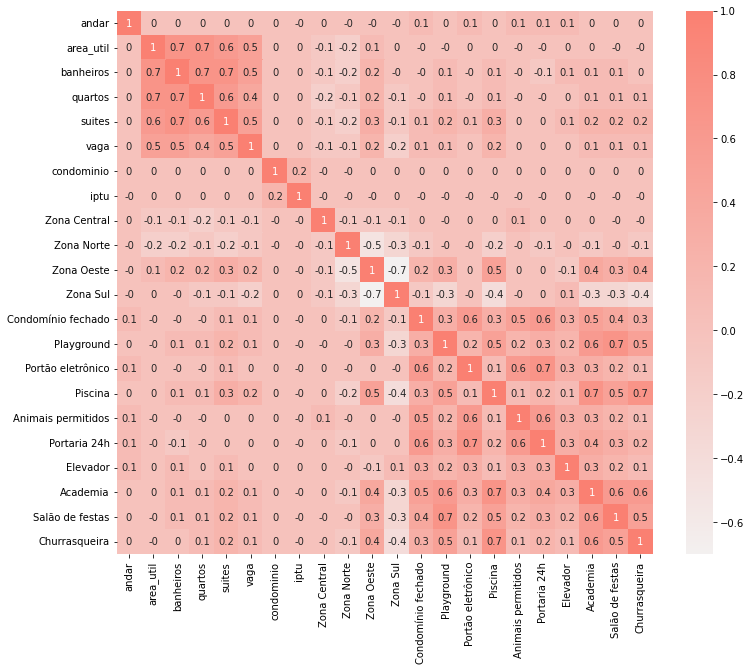

In [ ]:
# Plotando a correlação
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(df_correlacao.round(1), annot=True, cmap=paleta)

* Não foi observado nenhuma correlação considerada forte

# Criação dos Modelos


## Linear Regression

In [ ]:
# Separando os dados em 70% para treino e 30% para teste
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=3)

In [ ]:
# Contagem dos dados separados
print(f"Treino: {treino.count()} | Teste: {teste.count()}")

Treino: 37511 | Teste: 16166


In [ ]:
# Instânciando o modelo de regressão linear
lr = LinearRegression()

In [ ]:
# Treinando o modelo com os dados de treino
modelo_lr = lr.fit(dataset=treino)

In [ ]:
# Gerando previsões com os dados de treino
previsao_treino = modelo_lr.transform(treino)
previsao_treino.show(n=5)

+--------------------+---------+-----------------+
|            features|    label|       prediction|
+--------------------+---------+-----------------+
|(22,[0,1,2,3,4,5,...| 262000.0|738005.7898309974|
|(22,[0,1,2,3,4,5,...| 500000.0|732143.6225756299|
|(22,[0,1,2,3,4,5,...| 659000.0|781941.7149877151|
|(22,[0,1,2,3,4,5,...| 600000.0|866081.4525189355|
|(22,[0,1,2,3,4,5,...|2450000.0|3906445.925093687|
+--------------------+---------+-----------------+
only showing top 5 rows



In [ ]:
# Gerando previsões com os dados de teste
previsao_teste = modelo_lr.transform(teste)
previsao_teste.show(n=5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 800000.0| 746198.7525710424|
|(22,[0,1,2,3,4,5,...| 690000.0| 695286.5977066882|
|(22,[0,1,2,3,4,5,...| 650000.0| 690948.0906787853|
|(22,[0,1,2,3,4,5,...|1250000.0|1270539.6213078403|
|(22,[0,1,2,3,4,5,...| 340000.0|309104.97181997413|
+--------------------+---------+------------------+
only showing top 5 rows



### Avaliação

In [ ]:
# Criando métricas sobre o modelo
avaliacao_treino = modelo_lr.evaluate(treino)

In [ ]:
# Gerando avaliação sobre os dados de teste
avaliacao_teste = modelo_lr.evaluate(teste)

In [ ]:
# R2 - Ajuste do modelo aos dados
# RMESE - Avaliação dos erros do modelo
print('Linear Regression')
print("-"*30)
print("Dados de Treino")
print("-"*30)
print(f"R²:{avaliacao_treino.r2}")
print(f"RMSE: {avaliacao_treino.rootMeanSquaredError}")
print("")
print("-"*30)
print("Dados de Teste")
print("-"*30)
print(f"R²:{avaliacao_teste.r2}")
print(f"RMSE: {avaliacao_teste.rootMeanSquaredError}")

Linear Regression
------------------------------
Dados de Treino
------------------------------
R²:0.6790701336872011
RMSE: 857865.8784947454

------------------------------
Dados de Teste
------------------------------
R²:0.661460783832051
RMSE: 847388.9670313671


## Decision Tree Regressor


In [ ]:
# Instânciando o modelo de Decision Tree Regressor (maxDepth com o valor 10 foi o que apresentou melhor performance)
dtr = DecisionTreeRegressor(seed=10, maxDepth=10)

In [ ]:
# Treinando o modelo
modelo_dtr = dtr.fit(treino)

In [ ]:
# Gerando previsões com os dados de treino
previsao_treino = modelo_dtr.transform(treino)
previsao_treino.show(n=5)

+--------------------+---------+-----------------+
|            features|    label|       prediction|
+--------------------+---------+-----------------+
|(22,[0,1,2,3,4,5,...| 262000.0|542719.5139573071|
|(22,[0,1,2,3,4,5,...| 500000.0|697917.6569343066|
|(22,[0,1,2,3,4,5,...| 659000.0|654397.5215053763|
|(22,[0,1,2,3,4,5,...| 600000.0|697917.6569343066|
|(22,[0,1,2,3,4,5,...|2450000.0|3514611.111111111|
+--------------------+---------+-----------------+
only showing top 5 rows



In [ ]:
# Gerando previsões com os dados de teste
previsao_teste_dtr = modelo_dtr.transform(teste)
previsao_teste_dtr.show(n=5)

+--------------------+---------+-----------------+
|            features|    label|       prediction|
+--------------------+---------+-----------------+
|(22,[0,1,2,3,4,5,...| 800000.0|573242.7975206611|
|(22,[0,1,2,3,4,5,...| 690000.0|573242.7975206611|
|(22,[0,1,2,3,4,5,...| 650000.0|573242.7975206611|
|(22,[0,1,2,3,4,5,...|1250000.0|804978.4673366834|
|(22,[0,1,2,3,4,5,...| 340000.0|457277.5455729167|
+--------------------+---------+-----------------+
only showing top 5 rows



### Avaliação

In [ ]:
# Instânciando o RegressionEvaluator (calcula as métricas R2 e RMSE)
evaluator = RegressionEvaluator()

In [ ]:
# R2 - Ajuste do modelo aos dados
# RMESE - Avaliação dos erros do modelo
print('Decision Tree Regression')
print("-"*30)
print("Dados de Treino")
print("-"*30)
print("R²: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "rmse"}))
print("")
print("-"*30)
print("Dados de Teste")
print("-"*30)
print("R²: %f" % evaluator.evaluate(previsao_teste_dtr, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsao_teste_dtr, {evaluator.metricName: "rmse"}))

Decision Tree Regression
------------------------------
Dados de Treino
------------------------------
R²: 0.879844
RMSE: 524911.642634

------------------------------
Dados de Teste
------------------------------
R²: 0.808634
RMSE: 637105.029844


## Random Forest

In [ ]:
# Instânciando o modelo de Random Forest
rfr = RandomForestRegressor(seed=10, maxDepth=14, numTrees=30)

In [ ]:
# Treinando o modelo com os dados de treino
modelo_rfr = rfr.fit(treino)

In [ ]:
# Gerando previsões com os dados de treino
previsao_treino = modelo_rfr.transform(treino)
previsao_treino.show(n=5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 262000.0|459579.93150954094|
|(22,[0,1,2,3,4,5,...| 500000.0| 574835.7760693228|
|(22,[0,1,2,3,4,5,...| 659000.0| 693835.8113615337|
|(22,[0,1,2,3,4,5,...| 600000.0| 673116.2616255492|
|(22,[0,1,2,3,4,5,...|2450000.0|2396257.2022222225|
+--------------------+---------+------------------+
only showing top 5 rows



In [ ]:
# Gerando previsões com os dados de teste
previsao_teste = modelo_rfr.transform(teste)
previsao_teste.show(n=5)

+--------------------+---------+-----------------+
|            features|    label|       prediction|
+--------------------+---------+-----------------+
|(22,[0,1,2,3,4,5,...| 800000.0|616090.8890661992|
|(22,[0,1,2,3,4,5,...| 690000.0|582568.4354890217|
|(22,[0,1,2,3,4,5,...| 650000.0|535972.2213520458|
|(22,[0,1,2,3,4,5,...|1250000.0| 939064.484593467|
|(22,[0,1,2,3,4,5,...| 340000.0|370298.7564562624|
+--------------------+---------+-----------------+
only showing top 5 rows



### Avaliação

In [ ]:
# R2 - Ajuste do modelo aos dados
# RMESE - Avaliação dos erros do modelo
print('Random Forest Regression')
print("-"*30)
print("Dados de Treino")
print("-"*30)
print("R²: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "rmse"}))
print("")
print("-"*30)
print("Dados de Teste")
print("-"*30)
print("R²: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
------------------------------
Dados de Treino
------------------------------
R²: 0.879844
RMSE: 524911.642634

------------------------------
Dados de Teste
------------------------------
R²: 0.856002
RMSE: 552657.589505
